# ATP and kinase conformations

This notebook analyses kinase conformations associated with ATP binding. The main goal is to identify relevant conformations for ATP binding and how Mg2+ ions are involved. This can later be used to reliably generate wildtype ATP/Mg2+ bound kinase conformations, which can be employed to predict the impact of point mutations on ATP affinity.

## Content

- Retrieve relevant kinase structures  
- ATP bound kinase conformations
- Number of co-crystallized Mg2+ ions
- Critical residues for ATP/Mg binding
- Sidechain dihedrals
- G-rich loop conformations
  - KLIFS descriptors
  - backbone dihedrals

In [1]:
import collections
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from opencadd.databases.klifs import setup_remote
import MDAnalysis as mda
from openeye import oechem
from kinoml.modeling.OEModeling import read_molecules

INFO:opencadd.databases.klifs.api:If you want to see an non-truncated version of the DataFrames in this module, use `pd.set_option('display.max_columns', 50)` in your notebook.


## Retrieve relevant kinase structures

Kinase structures will be retrieved from the [KLIFS database](https://klifs.vu-compmedchem.nl/) and filtered to find the most relevant structures.

In [2]:
# Set up remote session
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


In [3]:
# retrieve kinase structures
kinase_df = remote.structures.all_structures()
# remove NMR structures
kinase_df = kinase_df[kinase_df["structure.resolution"].notna()]
print("Number of PDB entries:", len(set(kinase_df["structure.pdb_id"])))
print("Number of KLIFS entries:", len(kinase_df))
kinase_df.tail()

Number of PDB entries: 5324
Number of KLIFS entries: 11478


,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,...,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
11696,9142,4d0m,-,S,Human,1090,PI4KB,None,None,VVLNSKDKAPYLIVIVKCGDLRQELLAFQVLKLWIKPYKILSGMIE...,...,False,False,False,False,False,False,19.0418,61.5099,68.9944,None
11697,9096,4wtv,B,B,Human,1091,PI4K2B,None,None,ERIS___SGSYFVGVFKPKGYLSEAGAYLVDNSIVPKTKVVGSFQL...,...,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
11698,9098,4wtv,B,A,Human,1091,PI4K2B,None,None,ERISQGSSGSYFVGVFKPKGYLSEAGAYLVDNSIVPKTKVVGSFQL...,...,False,False,False,False,False,False,19.2476,61.8136,21.5262,None
11699,9097,4wtv,A,B,Human,1091,PI4K2B,None,None,ERIS___SGSYFVGVFKPKGYLSEAGAYLVDNSIVPKTKVVGSFQL...,...,False,False,False,False,False,False,0.0000,0.0000,0.0000,None
11700,9095,4wtv,A,A,Human,1091,PI4K2B,None,None,ERISQGSSGSYFVGVFKPKGYLSEAGAYLVDNSIVPKTKVVGSFQL...,...,False,False,False,False,False,False,19.2476,61.8136,21.5262,None


Since the focus is on ATP binding, entries will be scanned for ATP in the orthosteric pocket. Also, entries will be removed that have more than one ligand in the orthosteric pocket or have an additional allosteric binder. This ensures a clean "unbiased" ATP binding mode.

In [4]:
# filter for entries with ATP in the binding pocket
atp_df = kinase_df[kinase_df["ligand.expo_id"] == "ATP"]
print("Number of PDB entries:", len(set(atp_df["structure.pdb_id"])))
print("Number of KLIFS entries:", len(atp_df))

Number of PDB entries: 111
Number of KLIFS entries: 214


In [5]:
# filter for entries with a single orthosteric ligand
atp_df = atp_df.groupby("structure.pdb_id").filter(lambda x: len(set(x["ligand.expo_id"])) == 1)
print("Number of PDB entries:", len(set(atp_df["structure.pdb_id"])))
print("Number of KLIFS entries:", len(atp_df))

Number of PDB entries: 111
Number of KLIFS entries: 214


In [6]:
# filter for entries that do not contain an allosteric ligand, since this might affect the conformation
atp_df = atp_df[atp_df["ligand_allosteric.expo_id"] == "-"]
print("Number of PDB entries:", len(set(atp_df["structure.pdb_id"])))
print("Number of KLIFS entries:", len(atp_df))

Number of PDB entries: 82
Number of KLIFS entries: 153


To reduce noise, the entries will be further filtered to retrieve 1 entry per PDB identifier. KLIFS reports a quality score, which is used to pick the "best" quality chain and alternate location for further analysis.

In [7]:
# sort by alt, chain and quality score to pick representative structure in next step
atp_df = atp_df.sort_values(by=["structure.qualityscore", 
                                "structure.resolution",
                                "structure.alternate_model",
                                "structure.chain"], 
                            ascending=[False, True, True, True])
# keep entry with highest quality score
atp_df = atp_df.groupby("structure.pdb_id").head(1)
print("Number of PDB entries:", len(set(atp_df["structure.pdb_id"])))
print("Number of KLIFS entries:", len(atp_df))

Number of PDB entries: 82
Number of KLIFS entries: 82


## ATP bound kinase conformations

It would be interesting to identify the conformations that kinases prefere to bind ATP. Let's find all DFG and $\alpha$C helix conformations deposited in KLIFS for the filtered entries. Once available in KinoML this analysis can be carried out with the Dunbrack classification.

<AxesSubplot:>

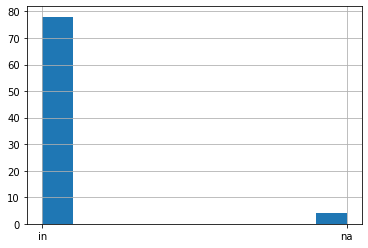

In [8]:
atp_df["structure.dfg"].hist()

In [9]:
atp_df[atp_df["structure.dfg"] == "na"]["structure.pdb_id"]

6457     3gni
10161    3rep
10159    3kmw
710      4fg8
Name: structure.pdb_id, dtype: object

Not surprisingly, most kinases show a DFG in conformation, which positions the Asp of the DFG motif in the binding site. This is important, since the DFG Asp complexes Mg2+ to bind the ATP's phosphate groups ([Modi 2018](https://doi.org/10.1073/pnas.1814279116)). The entries reptorting a `'na'` DFG conformation have either missing residues in the DFG motif or are special kinases that do not contain the DFG motif. We will delete those for now from further analysis. However, those entries might be interesting later to analyze the effect of very central loss of function mutations in the DFG motif.

In [10]:
atp_df = atp_df[atp_df["structure.dfg"] != "na"]

Next the $\alpha$C helix conformations.

<AxesSubplot:>

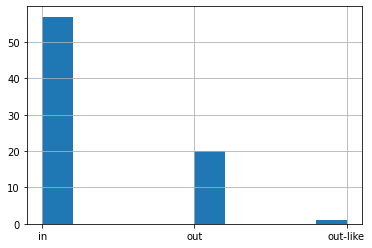

In [11]:
atp_df["structure.ac_helix"].hist()

According to the published literature, active kinase conformations, i.e., bound to ATP, should show an $\alpha$C helix in conformation [Modi 2018](https://doi.org/10.1073/pnas.1814279116). Surprisingly, ~30 % of pdb entries show an $\alpha$C helix out or out-like conformation.

In [12]:
print(atp_df[atp_df["structure.ac_helix"] != "in"]["structure.pdb_id"].to_list())

['2y4i', '4fvq', '3dkc', '5i4n', '1hck', '1b38', '4fvr', '3vvh', '1b39', '4an3', '3dv3', '1s9j', '3e8n', '3eqb', '3dy7', '3pp1', '3os3', '1ua2', '5d9h', '1s9i', '4fg9']


The untypical $\alpha$C helix conformation can be explained by ***several mutations*** (4fvq, 4fvr, 5i4n), ***dependency on other interaction partners*** (cyclin - 1b39, 1b38, 1ua2, 1hck, Ca2+/calmodulin - 4fg9) or ***additional ligands*** that were not reported by KLIFS (4an3, 3os3, 3dy7, 1s9j, 3e8n, 1s9i, 3pp1, 3vvh, 3dv3, 3eqb). For some entries it is less clear (STK39 - 5d9h, MAP2K1 - 2y4i, c-MET - 3dkc).

## Number of co-crystallized Mg2+ ions

Let's focus on the kinases with the active conformation (DFG in, $\alpha$C helix in). Split the dataset according to the number of co-crystalized Mg2+ ions.

In [13]:
# retrieve prealigned complexes from KLIFS for visualization in e.g. PyMol
directory = Path("~/data/kinases/atp").expanduser()
directory.mkdir(parents=True, exist_ok=True)

for index, structure in atp_df[atp_df["structure.dfg"] == "in"].iterrows():
    pdb_text = remote.coordinates.to_text(structure["structure.klifs_id"], extension="pdb")
    path = directory / f"{structure['structure.pdb_id']}.pdb"
    with open(path, "w") as wf:
        wf.write(pdb_text)

In [14]:
# save structures in different folders according to number of co-crystalized Mg2+ ions
directory_no_mg = Path("~/data/kinases/atp/no_mg").expanduser()
directory_no_mg.mkdir(parents=True, exist_ok=True)
directory_one_mg = Path("~/data/kinases/atp/one_mg").expanduser()
directory_one_mg.mkdir(parents=True, exist_ok=True)
directory_two_mg = Path("~/data/kinases/atp/two_mg").expanduser()
directory_two_mg.mkdir(parents=True, exist_ok=True)
directory_more_mg = Path("~/data/kinases/atp/more_mg").expanduser()
directory_more_mg.mkdir(parents=True, exist_ok=True)

no_mg = []
one_mg = []
two_mg = []
more_mg = []
for index, structure in atp_df[atp_df["structure.ac_helix"] == "in"].iterrows():
    path = directory / f"{structure['structure.pdb_id']}.pdb"
    u = mda.Universe(path)
    num_mg = len(u.select_atoms("resname MG"))
    if num_mg == 0:
        no_mg.append(structure["structure.pdb_id"])
        path = directory_no_mg / f"{structure['structure.pdb_id']}.pdb"
    elif num_mg == 1:
        one_mg.append(structure["structure.pdb_id"])
        path = directory_one_mg / f"{structure['structure.pdb_id']}.pdb"
    elif num_mg == 2:
        two_mg.append(structure["structure.pdb_id"])
        path = directory_two_mg / f"{structure['structure.pdb_id']}.pdb"
    else:
        more_mg.append(structure["structure.pdb_id"])
        path = directory_more_mg / f"{structure['structure.pdb_id']}.pdb"
    pdb_text = remote.coordinates.to_text(structure["structure.klifs_id"], extension="pdb")
    with open(path, "w") as wf:
            wf.write(pdb_text)

/home/david/miniconda3/envs/kinoml/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [15]:
print(f"{len(no_mg)} structures without Mg2+: {no_mg}")
print(f"{len(one_mg)} structures with one Mg2+: {one_mg}")
print(f"{len(two_mg)} structures with two Mg2+: {two_mg}")
print(f"{len(more_mg)} structures more than two Mg2+: {more_mg}")

23 structures without Mg2+: ['3hrc', '3fjq', '5lvp', '4wtv', '5cu6', '4rrv', '2cch', '4wb7', '2biy', '4xw5', '3a7h', '1h1w', '3a8w', '4btj', '2ijm', '1atp', '1fin', '2yaa', '1jst', '4fg7', '3hmn', '4wae', '1ol6']
15 structures with one Mg2+: ['4eoj', '4dh1', '4eoo', '4eom', '5drd', '4eoq', '1qmz', '2cjm', '5dt3', '1gy3', '2cci', '3blq', '1fq1', '5wni', '3bu5']
19 structures with two Mg2+: ['1rdq', '6zxg', '6zxf', '3qam', '6no7', '3qal', '4din', '4wb8', '4wb5', '3x2w', '3x2v', '5dnr', '3q53', '4wb6', '4dh3', '4x6r', '3x2u', '4xbr', '6byr']
0 structures more than two Mg2+: []


<AxesSubplot:>

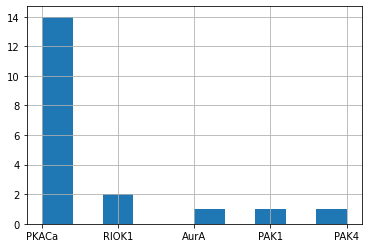

In [16]:
atp_df[atp_df["structure.pdb_id"].isin(two_mg)]["kinase.klifs_name"].hist()

Only 17 entries were found with the active DFG in/$\alpha$C helix in conformation and exactly two bound Mg2+ ions. Most of them belong to a single kinase type.

## Critical residues for ATP/Mg binding

ToDo: Use plipify to find critical interaction partners.

## Sidechain dihedrals

The prior analysis identified three residues (K17, N75, D81) as well as the G-rich loop backbone to be critical for ATP binding. Here, we  will analyze the conformations of the sidechains in terms of their dihedrals and compare those to DFG in/aC helix in structures in general.

In [17]:
def get_chi_dihedrals(hier_residue):
    """
    Get the sidechain dihedrals in radian.
    
    Parameters
    ----------
    hier_residue: oechem.OEHierResidue
        The residue of interest.
        
    Returns
    -------
    chi_dihedrals: list of float
        The sidechain dihedrals.
    """
    chi_dihedrals = []
    
    for chi_id in range(5):
        if chi_id == 0:
            dihedral = oechem.OEGetTorsion(hier_residue, oechem.OEProtTorType_Chi1)
        elif chi_id == 1:
            dihedral = oechem.OEGetTorsion(hier_residue, oechem.OEProtTorType_Chi2)
        elif chi_id == 2:
            dihedral = oechem.OEGetTorsion(hier_residue, oechem.OEProtTorType_Chi3)
        elif chi_id == 3:
            dihedral = oechem.OEGetTorsion(hier_residue, oechem.OEProtTorType_Chi4)
        else:
            dihedral = oechem.OEGetTorsion(hier_residue, oechem.OEProtTorType_Chi5)
        if dihedral == -100:
            break
            
        chi_dihedrals.append(dihedral)

    return chi_dihedrals

In [18]:
def klifs_to_pdb_resids(klifs_resids, klifs_structure_id):
    """
    Convert klifs pocket resids into the corresponding pdb resids of the 
    specified klifs structure.
    
    Parameters
    ----------
    klifs_resids: list of int
        KLIFS pocket residue ids.
    klifs_structure_id: int
        KLIFS structure ID of the structure to get the corresponding pdb resids for.
        
    Returns
    -------
    convert_dict: dict
        The dictionary with klifs resids as keys and pdb resids as values.
    """    
    
    pocket = remote.pockets.by_structure_klifs_id(klifs_structure_id)
    pdb_resids = pocket[pocket["residue.klifs_id"].isin(klifs_resids)]["residue.id"].to_list()
    convert_dict = {klifs_resid: int(pdb_resid) for klifs_resid, pdb_resid in zip(klifs_resids, pdb_resids) if pdb_resid != "_"}
    
    return convert_dict

In [19]:
active_conformations_path = Path("~/data/kinases/active_conformations").expanduser()
active_conformations_path.mkdir(parents=True, exist_ok=True)
critical_sidechains = collections.OrderedDict({17: "LYS", 75: "ASN", 81: "ASP"})
chi_dihedrals_names = ["LYS17_chi1", "LYS17_chi2", "LYS17_chi3", "LYS17_chi4",
                       "ASN75_chi1", "ASN75_chi2",
                       "ASP81_chi1", "ASP81_chi2"]
dihedrals_dict = {}
active_conformations = kinase_df[(kinase_df["structure.dfg"] == "in") & 
                                 (kinase_df["structure.ac_helix"] == "in")]

In [20]:
# get critical sidechain dihedrals for all DFG in/aC helix structures in KLIFS
for index, structure in tqdm(active_conformations.iterrows(), 
                             total=active_conformations.shape[0]):
    path = active_conformations_path / f"{structure['structure.klifs_id']}.pdb"
    if not path.is_file():
        pdb_text = remote.coordinates.to_text(structure["structure.klifs_id"], extension="pdb")
        with open(path, "w") as wf:
            wf.write(pdb_text)
    pdb_structure = read_molecules(path)[0]
    klifs_to_pdb_dict = klifs_to_pdb_resids(critical_sidechains.keys(), structure["structure.klifs_id"])
    if len(klifs_to_pdb_dict) == len(critical_sidechains):
        dihedrals_list = []
        hier_view = oechem.OEHierView(pdb_structure)
        for klifs_resid, resname in critical_sidechains.items():
            hier_residue = hier_view.GetResidue(structure["structure.chain"], resname, klifs_to_pdb_dict[klifs_resid])
            if len(list(hier_residue.GetAtoms())) > 0:
                dihedrals_list += get_chi_dihedrals(hier_residue)
        if len(chi_dihedrals_names) == len(dihedrals_list):
            dihedrals_dict[structure["structure.klifs_id"]] = dihedrals_list
print(f"Number of structures with all critical dihedrals present: {len(dihedrals_dict)}")

100%|██████████| 7237/7237 [38:09<00:00,  3.16it/s]  

Number of structures with all critical dihedrals present: 6996


In [21]:
dihedrals_df = pd.DataFrame.from_dict(dihedrals_dict, orient="index", columns=chi_dihedrals_names)
dihedrals_df.to_csv("sidechain_dihedrals.csv")

In [22]:
dihedrals_df = pd.read_csv("sidechain_dihedrals.csv", index_col=0)

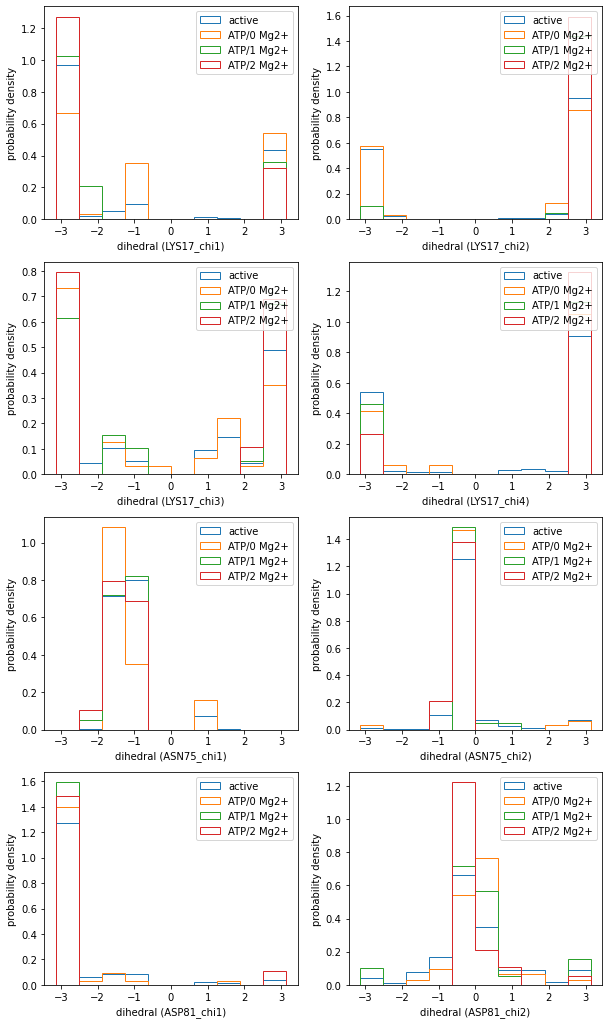

In [23]:
# plot dihedral distributions for all kinases in an active conformation and those bound to ATP
no_mg_klifs_ids = kinase_df[kinase_df["structure.pdb_id"].isin(no_mg)]["structure.klifs_id"].to_list()
one_mg_klifs_ids = kinase_df[kinase_df["structure.pdb_id"].isin(one_mg)]["structure.klifs_id"].to_list()
two_mg_klifs_ids = kinase_df[kinase_df["structure.pdb_id"].isin(two_mg)]["structure.klifs_id"].to_list()
fig, rows = plt.subplots(nrows=4, ncols=2, figsize=(10, 18))
counter = 0
for row in rows:
    for subplot in row:
        dihedral_name = chi_dihedrals_names[counter]
        subplot.hist(dihedrals_df[dihedral_name], 
                     histtype="step", 
                     density=True, 
                     range=(-3.14, 3.14),
                     label="active")
        subplot.hist(dihedrals_df[dihedrals_df.index.isin(no_mg_klifs_ids)][dihedral_name], 
                     histtype="step",
                     density=True, 
                     range=(-3.14, 3.14),
                     label="ATP/0 Mg2+")
        subplot.hist(dihedrals_df[dihedrals_df.index.isin(one_mg_klifs_ids)][dihedral_name], 
                     histtype="step",
                     density=True, 
                     range=(-3.14, 3.14),
                     label="ATP/1 Mg2+")
        subplot.hist(dihedrals_df[dihedrals_df.index.isin(two_mg_klifs_ids)][dihedral_name],
                     histtype="step",
                     density=True, 
                     range=(-3.14, 3.14),
                     label="ATP/2 Mg2+")
        subplot.set_ylabel("probability density")
        subplot.set_xlabel(f"dihedral ({dihedral_name})")
        subplot.legend()
        counter += 1

From these plots its hard to say which dihedrals are preferred, since the kinase structures with two Mg2+ are of only few kinase types. However, if ignoring this fact, one can identify clear preferences.

## G-rich loop conformations

The G-rich loop of kinases can act as a lid on top of the ATP binding pocket. When comparing [2F4J](https://www.rcsb.org/structure/2F4J) and [1RDQ](https://www.rcsb.org/structure/1RDQ) (both DFG in/aC helix in), one can observe very different G-rich loop conformations. Since the backbone nitrogens of the G-rich loop interact with the ATP phospate groups, it may be important to pick the right structure with a suitable G-rich loop conformation when modeling ATP complexes.

### KLIFS descriptors

The KLIFS kinase offers three different parameters to describe the conformation of the G-rich loop, i.e., angle, distance and rotation (see [supplementary information](https://doi.org/10.1093/nar/gkv1082)). Let's compare those descriptors between ATP bound structures in the DFG in/aC helix in conformation with all other kinase entries. Since angle and distance correlate heavily, it is probably sufficient to plot angle and rotation.

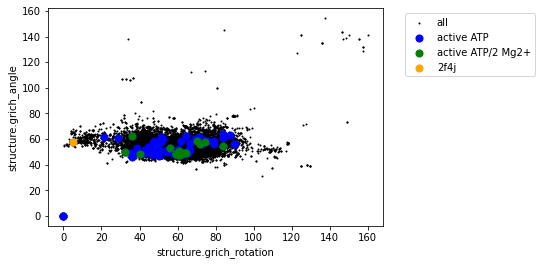

In [24]:
ax1 = kinase_df.plot.scatter(x="structure.grich_rotation", 
                             y="structure.grich_angle", 
                             label="all",
                             s=1, c="black")
ax1.scatter(x=atp_df["structure.grich_rotation"], 
            y=atp_df["structure.grich_angle"], 
            label="active ATP",
            s=50, c="blue")
ax1.scatter(x=atp_df[atp_df["structure.pdb_id"].isin(two_mg)]["structure.grich_rotation"], 
            y=atp_df[atp_df["structure.pdb_id"].isin(two_mg)]["structure.grich_angle"],
            label="active ATP/2 Mg2+",
            s=50, c="green")
ax1.scatter(x=kinase_df[kinase_df["structure.pdb_id"] == "2f4j"]["structure.grich_rotation"], 
            y=kinase_df[kinase_df["structure.pdb_id"] == "2f4j"]["structure.grich_angle"],
            label="2f4j",
            s=50, c="orange")
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

Looking at the scatter plot and several representative structures it turned out that none of the KLIFS provided G rich loop descriptors can be used to reliably identify a G rich loop conformation found for ATP bound structures.

### Backbone dihedrals

Since the KLIFS descriptors cannot be used to identify ATP-binding competent for the G-rich loop conformations, we will look at the backbone dihedrals of corrsponding residues. Those dihedrals might be able to infer the secondary structure of the G-loop and thus a stretched conformation. 

In [25]:
def get_backbone_dihedrals(hier_residue):
    """
    Get the backbone dihedrals in radian.
    
    Parameters
    ----------
    hier_residue: oechem.OEHierResidue
        The residue of interest.
        
    Returns
    -------
    backbone_dihedrals: list of float
        The backbone dihedrals.
    """
    backbone_dihedrals = [
        oechem.OEGetTorsion(hier_residue, oechem.OEProtTorType_Phi),
        oechem.OEGetTorsion(hier_residue, oechem.OEProtTorType_Psi),
        oechem.OEGetTorsion(hier_residue, oechem.OEProtTorType_Omega)]

    return backbone_dihedrals

In [26]:
active_conformations_path = Path("~/data/kinases/active_conformations").expanduser()
active_conformations_path.mkdir(parents=True, exist_ok=True)
critical_backbone_klifs_ids = [4, 5, 6, 7, 8, 9]
backbone_dihedrals_names = ["4_phi", "4_psi", "4_omega",
                            "5_phi", "5_psi", "5_omega",
                            "6_phi", "6_psi", "6_omega",
                            "7_phi", "7_psi", "7_omega",
                            "8_phi", "8_psi", "8_omega",
                            "9_phi", "9_psi", "9_omega"]
backbone_dihedrals_dict = {}
active_conformations = kinase_df[(kinase_df["structure.dfg"] == "in") & 
                                 (kinase_df["structure.ac_helix"] == "in")]

In [27]:
# get G-rich loop backbone dihedrals for all DFG in/aC helix structures in KLIFS
for index, structure in tqdm(active_conformations.iterrows(), 
                             total=active_conformations.shape[0]):
    path = active_conformations_path / f"{structure['structure.klifs_id']}.pdb"
    if not path.is_file():
        pdb_text = remote.coordinates.to_text(structure["structure.klifs_id"], extension="pdb")
        with open(path, "w") as wf:
            wf.write(pdb_text)
    pdb_structure = read_molecules(path)[0]
    klifs_to_pdb_dict = klifs_to_pdb_resids(critical_backbone_klifs_ids, structure["structure.klifs_id"])
    if len(klifs_to_pdb_dict) == len(critical_backbone_klifs_ids):
        dihedrals_list = []
        hier_view = oechem.OEHierView(pdb_structure)
        for hier_residue in hier_view.GetResidues():
            if hier_residue.GetResidueNumber() in klifs_to_pdb_dict.values():
                dihedrals_list += [x for x in get_backbone_dihedrals(hier_residue) if x != -100]
        if len(backbone_dihedrals_names) == len(dihedrals_list):
            backbone_dihedrals_dict[structure["structure.klifs_id"]] = dihedrals_list
print(f"Number of structures with all critical backbone dihedrals present: {len(backbone_dihedrals_dict)}")

100%|██████████| 7237/7237 [44:26<00:00,  2.71it/s]  

Number of structures with all critical backbone dihedrals present: 6331


In [28]:
backbone_dihedrals_df = pd.DataFrame.from_dict(backbone_dihedrals_dict, orient="index", columns=backbone_dihedrals_names)
backbone_dihedrals_df["mean"] = backbone_dihedrals_df.mean(axis=1)
backbone_dihedrals_df.to_csv("backbone_dihedrals.csv")

In [29]:
backbone_dihedrals_df = pd.read_csv("backbone_dihedrals.csv", index_col=0)

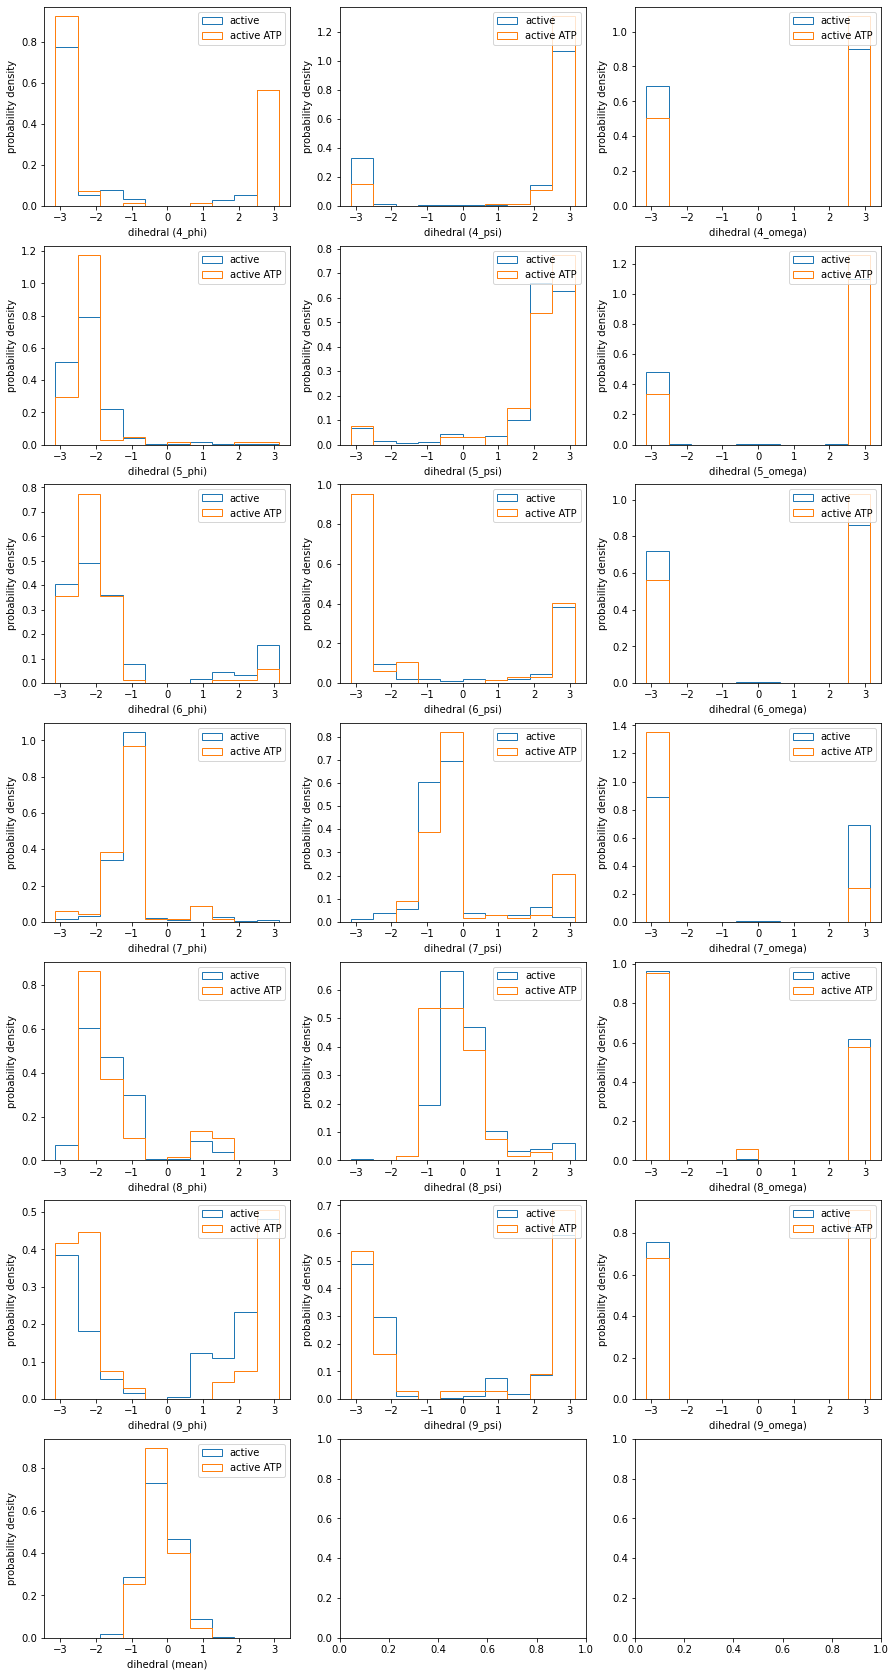

In [30]:
# plot dihedral distributions for all kinases in an active conformation and those bound to ATP
atp_klifs_ids = kinase_df[kinase_df["structure.pdb_id"].isin(no_mg + one_mg + two_mg)]["structure.klifs_id"].to_list()
fig, rows = plt.subplots(nrows=7, ncols=3, figsize=(15, 30))
counter = 0
for row in rows:
    for subplot in row:
        if counter == len(backbone_dihedrals_df.columns):
            break
        dihedral_name = backbone_dihedrals_df.columns[counter]
        subplot.hist(backbone_dihedrals_df[dihedral_name], 
                     histtype="step", 
                     density=True, 
                     range=(-3.14, 3.14),
                     label="active")
        subplot.hist(backbone_dihedrals_df[backbone_dihedrals_df.index.isin(atp_klifs_ids)][dihedral_name], 
                     histtype="step",
                     density=True, 
                     range=(-3.14, 3.14),
                     label="active ATP")
        subplot.set_ylabel("probability density")
        subplot.set_xlabel(f"dihedral ({dihedral_name})")
        subplot.legend()
        counter += 1

Descriminating ATP bound stretched G-loop conformation appears not to be easy with these plots. Another visualization possibilities are Ramachandran plots showing phi and psi angles as scatter plots. Those are especially informative since they report secondary structures like helices and sheets (see below). A stretched G-loop conformation should thereby report more beta sheet like dihedrals.

![ramachandran plot](http://www.cryst.bbk.ac.uk/PPS95/course/3_geometry/rama.gif)

[source](http://www.cryst.bbk.ac.uk/PPS95/course/3_geometry/rama.html)

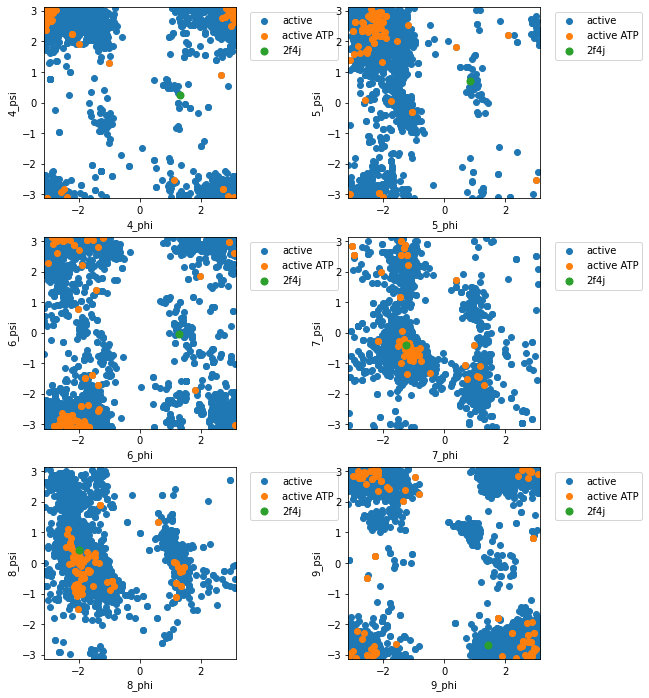

In [31]:
# phi psi scatter with highlighting 2f4j
atp_klifs_ids = kinase_df[kinase_df["structure.pdb_id"].isin(no_mg + one_mg + two_mg)]["structure.klifs_id"].to_list()
klifs_ids_2f4j = kinase_df[kinase_df["structure.pdb_id"] == "2f4j"]["structure.klifs_id"].to_list()
fig, rows = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
counter = 0
for row in rows:
    for subplot in row:
        klifs_resid = critical_backbone_klifs_ids[counter]
        subplot.scatter(x=backbone_dihedrals_df[f"{klifs_resid}_phi"],
                        y=backbone_dihedrals_df[f"{klifs_resid}_psi"],
                        label="active")
        subplot.scatter(x=backbone_dihedrals_df[backbone_dihedrals_df.index.isin(atp_klifs_ids)][f"{klifs_resid}_phi"],
                        y=backbone_dihedrals_df[backbone_dihedrals_df.index.isin(atp_klifs_ids)][f"{klifs_resid}_psi"],
                        label="active ATP")
        subplot.scatter(x=backbone_dihedrals_df[backbone_dihedrals_df.index.isin(klifs_ids_2f4j)][f"{klifs_resid}_phi"],
                        y=backbone_dihedrals_df[backbone_dihedrals_df.index.isin(klifs_ids_2f4j)][f"{klifs_resid}_psi"],
                        s=50,
                        label="2f4j")
        subplot.set_aspect('equal')
        subplot.set_xlim([-3.14, 3.14])
        subplot.set_ylim([-3.14, 3.14])
        subplot.set_ylabel(f"{klifs_resid}_psi")
        subplot.set_xlabel(f"{klifs_resid}_phi")
        subplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        counter += 1

In case of 2f4j, 5 out of 6 residues from the G-rich loop conformation have helix like phi and psi angles. Thus, one could try to find a G-rich loop confomation with less helix like dihedrals to pick the most suitable conformation for ATP modeling.

### Secondary structure

Since the phi and psi dihedrals correspond to different secondary structures, i.e., helix, sheet, and turns, one could calculate the statistics of secondary structures in the G-rich loop. The helix like G-rich loop of 2f4j should clearly pop out.

In [32]:
active_conformations_path = Path("~/data/kinases/active_conformations").expanduser()
active_conformations_path.mkdir(parents=True, exist_ok=True)
critical_backbone_klifs_ids = [4, 5, 6, 7, 8, 9]
secondary_structure_types = ["Helix", "Sheet", "Turn"]
secondary_structure_dict = {}
active_conformations = kinase_df[(kinase_df["structure.dfg"] == "in") & 
                                 (kinase_df["structure.ac_helix"] == "in")]

In [33]:
# get G-rich loop backbone dihedrals for all DFG in/aC helix structures in KLIFS
for index, structure in tqdm(active_conformations.iterrows(), 
                             total=active_conformations.shape[0]):
    path = active_conformations_path / f"{structure['structure.klifs_id']}.pdb"
    if not path.is_file():
        pdb_text = remote.coordinates.to_text(structure["structure.klifs_id"], extension="pdb")
        with open(path, "w") as wf:
            wf.write(pdb_text)
    pdb_structure = read_molecules(path)[0]
    klifs_to_pdb_dict = klifs_to_pdb_resids(critical_backbone_klifs_ids, structure["structure.klifs_id"])
    if len(klifs_to_pdb_dict) == len(critical_backbone_klifs_ids):
        secondary_structure_list = []
        hier_view = oechem.OEHierView(pdb_structure)
        for hier_residue in hier_view.GetResidues():
            if hier_residue.GetResidueNumber() in klifs_to_pdb_dict.values():
                oe_residue = hier_residue.GetOEResidue()
                secondary_structure_list.append(oechem.OEGetSecondaryStructureName(oe_residue.GetSecondaryStructure()))
        if len(critical_backbone_klifs_ids) == len(secondary_structure_list):
            secondary_structure_dict[structure["structure.klifs_id"]] = [
                len([x for x in secondary_structure_list if y in x]) for y in secondary_structure_types
            ]
print(f"Number of structures with all critical residues present: {len(secondary_structure_dict)}")

100%|██████████| 7237/7237 [46:36<00:00,  2.59it/s]  

Number of structures with all critical residues present: 6346


In [34]:
secondary_structure_df = pd.DataFrame.from_dict(secondary_structure_dict, orient="index", columns=secondary_structure_types)
secondary_structure_df.to_csv("secondary_structure.csv")

In [35]:
secondary_structure_df = pd.read_csv("secondary_structure.csv", index_col=0)

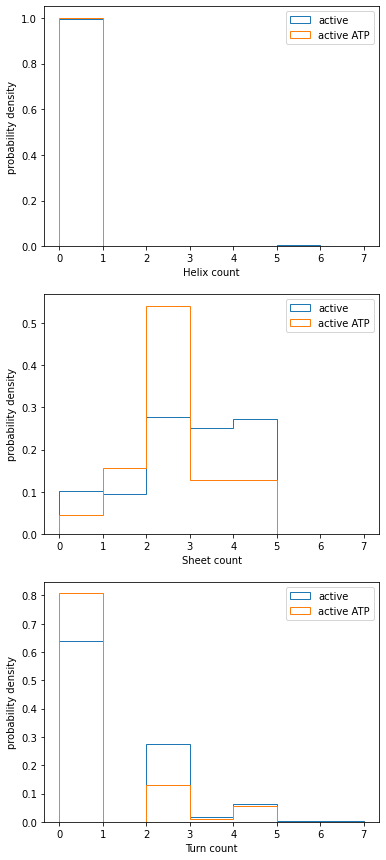

In [36]:
# plot dihedral distributions for all kinases in an active conformation and those bound to ATP
atp_klifs_ids = kinase_df[kinase_df["structure.pdb_id"].isin(no_mg + one_mg + two_mg)]["structure.klifs_id"].to_list()
fig, rows = plt.subplots(nrows=3, ncols=1, figsize=(6, 15))
counter = 0
for subplot in rows:
    secondary_structure_name = secondary_structure_df.columns[counter]
    subplot.hist(secondary_structure_df[secondary_structure_name], 
                 histtype="step", 
                 density=True,
                 bins=[0, 1, 2, 3, 4, 5, 6, 7],
                 label="active")
    subplot.hist(secondary_structure_df[secondary_structure_df.index.isin(atp_klifs_ids)][secondary_structure_name], 
                 histtype="step",
                 density=True,
                 bins=[0, 1, 2, 3, 4, 5, 6, 7],
                 label="active ATP")
    subplot.set_ylabel("probability density")
    subplot.set_xlabel(f"{secondary_structure_name} count")
    subplot.legend()
    counter += 1

In [37]:
helical_p_loops = secondary_structure_df[secondary_structure_df["Helix"] > 0].index.to_list()
non_helical_p_loops = secondary_structure_df[secondary_structure_df["Helix"] == 0].index.to_list()
kinases_with_both_conformations = set(
    kinase_df[kinase_df["structure.klifs_id"].isin(helical_p_loops)]["kinase.klifs_id"]
    ).intersection(set(
        kinase_df[kinase_df["structure.klifs_id"].isin(non_helical_p_loops)]["kinase.klifs_id"]
    )
)

In [38]:
for kinase_klifs_id in kinases_with_both_conformations:
    kinase_df_tmp = kinase_df[kinase_df["structure.klifs_id"].isin(helical_p_loops)]
    print(kinase_df[kinase_df["kinase.klifs_id"] == kinase_klifs_id].iloc[0]["kinase.klifs_name"],
          kinase_df[kinase_df["kinase.klifs_id"] == kinase_klifs_id].iloc[0]["species.klifs"])
    print("Helical", kinase_df_tmp[kinase_df_tmp["kinase.klifs_id"] == kinase_klifs_id]["structure.klifs_id"].to_list())
    kinase_df_tmp = kinase_df[kinase_df["structure.klifs_id"].isin(non_helical_p_loops)]
    print("Non-helical", kinase_df_tmp[kinase_df_tmp["kinase.klifs_id"] == kinase_klifs_id]["structure.klifs_id"].to_list())
    print("---------------------")

VRK1 Human
Helical [9810, 9815]
Non-helical [9421, 9422, 9423, 9769, 9770, 9082, 9085, 8030, 9417]
---------------------
AurA Human
Helical [2006]
Non-helical [2072, 8630, 6012, 6359, 8629, 8628, 2055, 2052, 8627, 6011, 6360, 6815, 6811, 2048, 8652, 6810, 12659, 12658, 8651, 2065, 2064, 12656, 2045, 8650, 12669, 12664, 8649, 6809, 8648, 6808, 6010, 2043, 6821, 10935, 8647, 11134, 6816, 11133, 11132, 2083, 2080, 2079, 2075, 2073, 8644, 12668, 10036, 8643, 12667, 8642, 8641, 8640, 12670, 2069, 8639, 10898, 8638, 8637, 12663, 12662, 8636, 8635, 12661, 8634, 8633, 12660, 6013, 8632, 8631, 2031, 6823, 2030, 2029, 6805, 1996, 1994, 1993, 6801, 1992, 1991, 6802, 1995, 2027, 6803, 1987, 1984, 1983, 1982, 1980, 1978, 1977, 1976, 1975, 2062, 2060, 1973, 1971, 1970, 8645, 1968, 2025, 2028, 6812, 2061, 6822, 2022, 1964, 1962, 10863, 9739, 1959, 1957, 1956, 1955, 1954, 10866, 9738, 1952, 11131, 11130, 9737, 9736, 8305, 7267, 7266, 8370, 10033, 7221, 10034, 6824, 8371, 7142, 7141, 6813, 10032, 6818,